In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!pip install tensorflow==2.4.1
#!pip install keras==2.4.3

In [ ]:
#!unzip -q "/content/drive/My Drive/data/tiny-imagenet-200.zip"

In [ ]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
#from keras.engine.topology import Network
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

#for inceptionv3
import keras

%matplotlib inline

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(121)
tf.random.set_seed(85)

In [ ]:
### Constants ###
DATA_DIR = "../tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

In [ ]:
def load_dataset_small(num_images_per_class_train=100, num_images_test=1000):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        #for img_name_i in c_imgs[0:num_images_per_class_train]:
        for img_name_i in c_imgs:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    #for img_name_i in test_imgs[0:num_images_test]:
    for img_name_i in test_imgs:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [ ]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 100000
Number of test examples = 10000
X_train shape: (100000, 64, 64, 3)


In [ ]:
del X_train_orig, X_test_orig

In [ ]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
one_fourth_X_train = X_train.shape[0] // 4
input_vanilla_S = X_train[0:one_fourth_X_train]
input_intruder_S = X_train[one_fourth_X_train: 2*one_fourth_X_train]

# C: cover image
input_vanilla_C = X_train[2*one_fourth_X_train: 3*one_fourth_X_train]
input_intruder_C = X_train[3*one_fourth_X_train:]

print ("Number of input_vanilla_S examples = " + str(input_vanilla_S.shape[0]))
print ("Number of input_intruder_S examples = " + str(input_intruder_S.shape[0]))
print ("Number of input_vanilla_C examples = " + str(input_vanilla_C.shape[0]))
print ("Number of input_intruder_C examples = " + str(input_intruder_C.shape[0]))

Number of input_vanilla_S examples = 25000
Number of input_intruder_S examples = 25000
Number of input_vanilla_C examples = 25000
Number of input_intruder_C examples = 25000


In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    rmse_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    rmse_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return rmse_Spixel, rmse_Cpixel

## Vanilla Model Implementation

In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(y_true, y_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(y_true - y_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    s_loss = K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    x = input_S
    
    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(x) #changed
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(x) #changed
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C], #changed
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))

    # Adding Gaussian noise with 0.01 standard deviation.
    x = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed
  
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    # else:
    #     return Container(inputs=reveal_input,
    #                      outputs=output_Sprime,
    #                      name = 'DecoderFixed')                    # Changed
#     else:
#       return Network(inputs= reveal_input,   #changed
#                       outputs=output_Sprime,
#                       name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size)) 
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C]) #changed
    output_Sprime = decoder(output_Cprime) #changed

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    return encoder, decoder, autoencoder

### 1st 10 epoch :

In [ ]:
def Train(e) :
  NB_EPOCHS = e
  BATCH_SIZE = 32
  m = input_vanilla_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_vanilla_S.shape[1:])
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_vanilla_S)
      np.random.shuffle(input_vanilla_C)
      
      t = tqdm(range(0, input_vanilla_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          
          batch_S = input_vanilla_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_vanilla_C[idx:min(idx + BATCH_SIZE, m)]
          
          C_prime = encoder_model.predict([batch_S, batch_C])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=C_prime,y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 24992 of 25000. Loss AE   14695.36 | Loss Rev    9641.88: 100%|██████████| 782/782 [13:11<00:00,  1.01s/it]
Epoch 2 | Batch: 24992 of 25000. Loss AE    6402.56 | Loss Rev    4304.15: 100%|██████████| 782/782 [12:38<00:00,  1.03it/s]
Epoch 3 | Batch: 24992 of 25000. Loss AE   11901.16 | Loss Rev    8833.96: 100%|██████████| 782/782 [12:31<00:00,  1.04it/s]
Epoch 4 | Batch: 24992 of 25000. Loss AE    4144.62 | Loss Rev    2783.15: 100%|██████████| 782/782 [12:33<00:00,  1.04it/s]
Epoch 5 | Batch: 24992 of 25000. Loss AE    3164.25 | Loss Rev    1939.58: 100%|██████████| 782/782 [12:32<00:00,  1.04it/s]
Epoch 6 | Batch: 24992 of 25000. Loss AE    2947.21 | Loss Rev    1773.32: 100%|██████████| 782/782 [12:30<00:00,  1.04it/s]
Epoch 7 | Batch: 24992 of 25000. Loss AE    2730.64 | Loss Rev    1617.13: 100%|██████████| 782/782 [12:32<00:00,  1.04it/s]
Epoch 8 | Batch: 24992 of 25000. Loss AE    2634.01 | Loss Rev    1550.44: 100%|██████████| 782/782 [12:37<00:00,  1.03it/s]


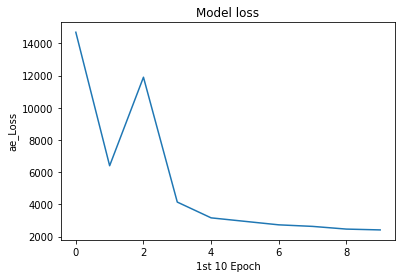

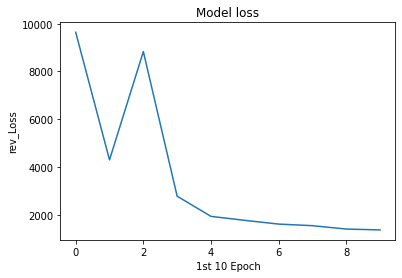

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(10)
autoencoder_model.save_weights('/content/drive/My Drive/Final_Model/vanilla_grey_1_intrusion/vanilla_grey_1_autoencoder_model_50k_10e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Final_Model/vanilla_grey_1_intrusion/vanilla_grey_1_encoder_model_50k_10e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Final_Model/vanilla_grey_1_intrusion/vanilla_grey_1_reveal_model_50k_10e.hdf5')

with open('/content/drive/My Drive/Final_Model/vanilla_grey_1_intrusion/vanilla_grey_1_autoencoder_50k_10e.txt', 'w') as f:
    for item in ae_loss_history:
        f.write("%s," % item)
with open('/content/drive/My Drive/Final_Model/vanilla_grey_1_intrusion/vanilla_grey_1_reveal_50k_10e.txt', 'w') as f:
    for item in rev_loss_history:
        f.write("%s," % item)

plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('1st 10 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('1st 10 Epoch')
plt.show()

## Intruder Model Implementation

In [ ]:
# Adding inception layer
# Code collected from https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init)(conv_5x5)

    #pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    #pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    #output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    output = concatenate([conv_1x1, conv_3x3, conv_5x5], axis=3, name=name)
    
    return output

In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(y_true, y_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(y_true - y_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    s_loss = K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    x = input_S
    
    # Preparation Network
    x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_1a')
    
    '''
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    '''
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_2a')
    
    '''
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    '''
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C], #changed
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))

    # Adding Gaussian noise with 0.01 standard deviation.
    x = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed
  
    x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')
    
    '''
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    '''
    
    x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_4a')
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    # else:
    #     return Container(inputs=reveal_input,
    #                      outputs=output_Sprime,
    #                      name = 'DecoderFixed')                    # Changed
#     else:
#       return Network(inputs= reveal_input,   #changed
#                       outputs=output_Sprime,
#                       name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size)) 
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C]) #changed
    output_Sprime = decoder(output_Cprime) #changed

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    return encoder, decoder, autoencoder

### 1st 10 epoch :

In [ ]:
def Train(e) :
  NB_EPOCHS = e
  BATCH_SIZE = 32
  m = input_intruder_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_intruder_S.shape[1:])
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_intruder_S)
      np.random.shuffle(input_intruder_C)
      
      t = tqdm(range(0, input_intruder_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          
          batch_S = input_intruder_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_intruder_C[idx:min(idx + BATCH_SIZE, m)]
          
          C_prime = encoder_model.predict([batch_S, batch_C])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=C_prime,y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

  0%|                                                   | 0/782 [00:00<?, ?it/s]2022-05-10 19:24:32.941433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-10 19:24:33.793152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-10 19:24:34.701198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Epoch 1 | Batch: 24960 of 25000. Loss AE    9078.31 | Loss Rev    4265.85: 100%|2022-05-10 19:35:48.157341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-10 19:35:48.479057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-10 19:35:49.115345: I tensorflow/core/grappler/optimizers

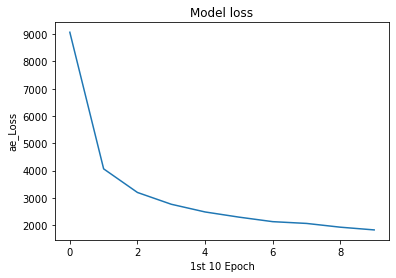

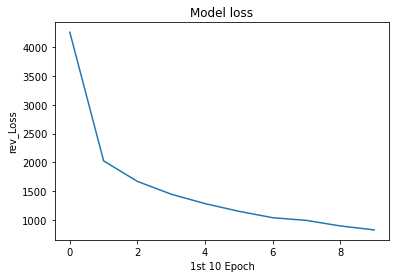

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(10)
autoencoder_model.save_weights('vanilla_grey_2_intruder_autoencoder_model_50k_10e.hdf5')
encoder_model.save_weights('vanilla_grey_2_intruder_encoder_model_50k_10e.hdf5')
reveal_model.save_weights('vanilla_grey_2_intruder_reveal_model_50k_10e.hdf5')

with open('vanilla_grey_2_intruder_autoencoder_50k_10e.txt', 'w') as f:
    for item in ae_loss_history:
        f.write("%s," % item)
with open('vanilla_grey_2_intruder_reveal_50k_10e.txt', 'w') as f:
    for item in rev_loss_history:
        f.write("%s," % item)

plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('1st 10 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('1st 10 Epoch')
plt.show()

## Test 

In [ ]:
one_fourth_X_test = X_test.shape[0] // 4
input_vanilla_S = X_test[0:one_fourth_X_test]
input_intruder_S = X_test[one_fourth_X_test: 2*one_fourth_X_test]

# C: cover image
input_vanilla_C = X_test[2*one_fourth_X_test: 3*one_fourth_X_test]
input_intruder_C = X_test[3*one_fourth_X_test:]

### Vanilla Test

In [ ]:
vanilla_encoder_model, vanilla_reveal_model, vanilla_autoencoder_model = make_model(input_vanilla_S.shape[1:])
vanilla_autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/vanilla_grey_1_intrusion/vanilla_grey_1_autoencoder_model_50k_10e.hdf5')
vanilla_encoder_model.load_weights('/content/drive/My Drive/Final_Model/vanilla_grey_1_intrusion/vanilla_grey_1_encoder_model_50k_10e.hdf5')
vanilla_reveal_model.load_weights('/content/drive/My Drive/Final_Model/vanilla_grey_1_intrusion/vanilla_grey_1_reveal_model_50k_10e.hdf5')

In [ ]:
vanilla_decoded = vanilla_autoencoder_model.predict([input_vanilla_S, input_vanilla_C])
vanilla_decoded_S, vanilla_decoded_C = vanilla_decoded[...,0:3], vanilla_decoded[...,3:6]

In [ ]:
vanilla_S_error, vanilla_C_error = pixel_errors(input_vanilla_S, input_vanilla_C, vanilla_decoded_S, vanilla_decoded_C)

print ("S error per pixel [0, 255]:", vanilla_S_error)
print ("C error per pixel [0, 255]:", vanilla_C_error)

S error per pixel [0, 255]: 16.963394
C error per pixel [0, 255]: 12.7626705


In [ ]:
vanilla_C_prime = vanilla_encoder_model.predict([input_vanilla_S, input_vanilla_C])

### Intruder Test

In [ ]:
intruder_encoder_model, intruder_reveal_model, intruder_autoencoder_model = make_model(input_intruder_S.shape[1:])
intruder_autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/vanilla_grey_1_intrusion/vanilla_grey_1_intruder_autoencoder_model_50k_10e.hdf5')
intruder_encoder_model.load_weights('/content/drive/My Drive/Final_Model/vanilla_grey_1_intrusion/vanilla_grey_1_intruder_encoder_model_50k_10e.hdf5')
intruder_reveal_model.load_weights('/content/drive/My Drive/Final_Model/vanilla_grey_1_intrusion/vanilla_grey_1_intruder_reveal_model_50k_10e.hdf5')

In [ ]:
intruder_decoded = intruder_autoencoder_model.predict([input_intruder_S, input_intruder_C])
intruder_decoded_S, intruder_decoded_C = intruder_decoded[...,0:3], intruder_decoded[...,3:6]

In [ ]:
intruder_S_error, intruder_C_error = pixel_errors(input_intruder_S, input_intruder_C, intruder_decoded_S, intruder_decoded_C)

print ("S error per pixel [0, 255]:", intruder_S_error)
print ("C error per pixel [0, 255]:", intruder_C_error)

S error per pixel [0, 255]: 9.931966
C error per pixel [0, 255]: 13.260734


In [ ]:
intruded_vanilla_decoded_S = intruder_reveal_model.predict([vanilla_C_prime])

In [ ]:
intruded_vanilla_rmse_Spixel = np.sqrt(np.mean(np.square(255*(input_vanilla_S - intruded_vanilla_decoded_S))))
print ("intruded_vanilla_rmse_Spixel [0, 255]:", intruded_vanilla_rmse_Spixel)

intruded_vanilla_rmse_Spixel [0, 255]: 132.78545


In [ ]:
arr_position = 1005

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


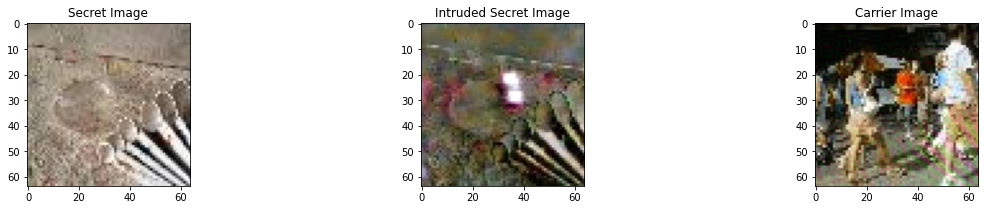

In [ ]:
fig, a = plt.subplots(1, 3, figsize=(20, 3))
a[0].imshow(input_vanilla_S[arr_position])
a[0].set_title('Secret Image')
a[1].imshow(intruded_vanilla_decoded_S[arr_position])
a[1].set_title('Intruded Secret Image')
a[2].imshow(vanilla_C_prime[arr_position])
a[2].set_title('Carrier Image')
plt.show()